In [2]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [3]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [4]:
class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [6]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Do not use normalization or activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]         
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [8]:
model = torch.load("/kaggle/input/saved-model-gan-20-epochs/model.pt")

In [9]:
type(model)

__main__.MainModel

In [10]:
model.forward

<bound method MainModel.forward of MainModel(
  (net_G): Unet(
    (model): UnetBlock(
      (model): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): UnetBlock(
          (model): Sequential(
            (0): LeakyReLU(negative_slope=0.2, inplace=True)
            (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): UnetBlock(
              (model): Sequential(
                (0): LeakyReLU(negative_slope=0.2, inplace=True)
                (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (3): UnetBlock(
                  (model): Sequential(
                    (0): LeakyReLU(negative_slope=0.2, inplace=True)
               

In [11]:
model.net_G

Unet(
  (model): UnetBlock(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

In [12]:
model.ab

tensor([[[[-3.5204e-03, -3.1047e-04,  1.3019e-03,  ...,  2.8733e-03,
           -1.3101e-02, -1.6275e-02],
          [-1.9197e-03, -3.1178e-04,  1.2994e-03,  ...,  2.8733e-03,
           -1.3101e-02, -1.6289e-02],
          [-3.1178e-04,  1.3045e-03,  1.2994e-03,  ...,  1.2842e-03,
           -9.9083e-03, -1.6289e-02],
          ...,
          [-2.7446e-03, -2.7291e-03,  5.1367e-03,  ...,  3.0586e-02,
            2.3765e-02,  1.1970e-02],
          [ 6.0213e-04, -2.7446e-03,  5.1367e-03,  ...,  2.5091e-02,
            2.9675e-02,  2.3155e-02],
          [ 1.1837e-02,  5.4367e-03,  9.9075e-03,  ...,  2.1820e-02,
            1.8247e-02,  1.8178e-02]],

         [[ 4.0192e-02,  3.0983e-02,  2.6329e-02,  ...,  3.1777e-02,
            3.6390e-02,  3.5255e-02],
          [ 3.5586e-02,  3.0952e-02,  2.6303e-02,  ...,  3.1777e-02,
            3.6390e-02,  3.5289e-02],
          [ 3.0952e-02,  2.6356e-02,  2.6303e-02,  ...,  3.6331e-02,
            3.7496e-02,  3.5289e-02],
          ...,
     

In [13]:
model.L.shape

torch.Size([16, 1, 256, 256])

In [43]:
model.L

tensor([[[[ 0.5182,  0.5192,  0.5343,  ...,  0.6008,  0.6008,  0.6065],
          [ 0.5187,  0.5265,  0.5416,  ...,  0.6008,  0.6008,  0.5992],
          [ 0.5265,  0.5270,  0.5416,  ...,  0.6003,  0.6023,  0.5992],
          ...,
          [ 0.5062,  0.4915,  0.4946,  ...,  0.5564,  0.5384,  0.5400],
          [ 0.5005,  0.5062,  0.4946,  ...,  0.5315,  0.5482,  0.5010],
          [ 0.4832,  0.5026,  0.5259,  ...,  0.5079,  0.5134,  0.5207]]],


        [[[-0.9380, -0.9400, -0.9452,  ..., -0.2626, -0.2015, -0.5992],
          [-0.9230, -0.9309, -0.9436,  ..., -0.1294, -0.2385, -0.6628],
          [-0.9300, -0.9428, -0.9341,  ..., -0.4259, -0.4677, -0.0259],
          ...,
          [-0.7011, -0.7163, -0.6788,  ..., -0.8702, -0.8244, -0.9037],
          [-0.6402, -0.6335, -0.6037,  ..., -0.8742, -0.8617, -0.8588],
          [-0.5674, -0.5066, -0.4416,  ..., -0.6729, -0.7440, -0.7221]]],


        [[[-0.3176, -0.3212, -0.3400,  ...,  0.1900,  0.1646,  0.1135],
          [-0.3090, -0.316

In [14]:
predictions = model.net_G(model.L)

In [15]:
type(predictions)

torch.Tensor

In [16]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [17]:
fake_imgs = lab_to_rgb(model.L, predictions.detach())
type(fake_imgs)

/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return func(*args, **kwargs)


numpy.ndarray

In [18]:
fake_imgs.shape

(16, 256, 256, 3)

In [19]:
fake_imgs[0].shape

(256, 256, 3)

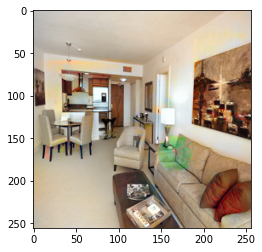

In [20]:
plt.imshow(fake_imgs[0])

In [44]:
randomArray = np.random.default_rng(42).random((2,1,256,256))
randomArray

array([[[[0.77395605, 0.43887844, 0.85859792, ..., 0.24783956,
          0.23666236, 0.74601428],
         [0.81656876, 0.10527808, 0.06655886, ..., 0.11585672,
          0.07205915, 0.84199321],
         [0.05556792, 0.28061144, 0.33413004, ..., 0.00925978,
          0.18832197, 0.03128351],
         ...,
         [0.39429248, 0.23362022, 0.20028336, ..., 0.83587403,
          0.99555317, 0.62312434],
         [0.98961291, 0.17804572, 0.62913015, ..., 0.88227855,
          0.20589677, 0.06855693],
         [0.66412461, 0.50934684, 0.59259855, ..., 0.22706128,
          0.58481748, 0.21348935]]],


       [[[0.25575828, 0.83143468, 0.63611776, ..., 0.61817492,
          0.29072522, 0.4254755 ],
         [0.27610337, 0.4419688 , 0.9842075 , ..., 0.99250327,
          0.69532921, 0.84761266],
         [0.1120067 , 0.69144593, 0.11847478, ..., 0.65208806,
          0.73103608, 0.28840358],
         ...,
         [0.33481224, 0.8406125 , 0.43903223, ..., 0.63576324,
          0.09408503, 0

In [52]:
randomArray = randomArray.astype(np.float32)

In [53]:
randomTensor = torch.from_numpy(randomArray)
randomTensor.float()
randomTensor = randomTensor.to(device)
randomTensor

tensor([[[[0.7740, 0.4389, 0.8586,  ..., 0.2478, 0.2367, 0.7460],
          [0.8166, 0.1053, 0.0666,  ..., 0.1159, 0.0721, 0.8420],
          [0.0556, 0.2806, 0.3341,  ..., 0.0093, 0.1883, 0.0313],
          ...,
          [0.3943, 0.2336, 0.2003,  ..., 0.8359, 0.9956, 0.6231],
          [0.9896, 0.1780, 0.6291,  ..., 0.8823, 0.2059, 0.0686],
          [0.6641, 0.5093, 0.5926,  ..., 0.2271, 0.5848, 0.2135]]],


        [[[0.2558, 0.8314, 0.6361,  ..., 0.6182, 0.2907, 0.4255],
          [0.2761, 0.4420, 0.9842,  ..., 0.9925, 0.6953, 0.8476],
          [0.1120, 0.6914, 0.1185,  ..., 0.6521, 0.7310, 0.2884],
          ...,
          [0.3348, 0.8406, 0.4390,  ..., 0.6358, 0.0941, 0.1097],
          [0.2413, 0.1463, 0.2713,  ..., 0.3216, 0.0174, 0.3103],
          [0.5209, 0.9854, 0.2905,  ..., 0.7458, 0.4348, 0.0799]]]],
       device='cuda:0')

In [54]:
type(randomTensor)

torch.Tensor

In [55]:
predictions = model.net_G(randomTensor)

In [56]:
fake_imgs2 = lab_to_rgb(randomTensor, predictions.detach())
type(fake_imgs2)

numpy.ndarray

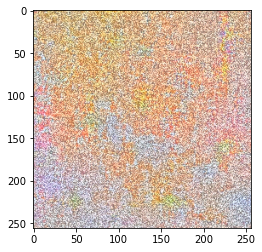

In [57]:
plt.imshow(fake_imgs2[0])